In [1]:
import numpy as np
import re
import os
import networkx as nx

In [2]:
pi=np.pi


vertices = ('V' , 'Er', 'Ti', 'Ce', 'S',
			'H' , 'He', 'Li', 'Be', 'B',
			'C' , 'N' , 'O' , 'F' , 'Ne',
			'Na', 'Mg', 'Al', 'Si', 'P',
			'Cl', 'Ar', 'K' , 'Ca', 'Sc',
			'Cr', 'Mn', 'Fe', 'Co', 'Ni',
			'Ac','Ag','Al','Am','Au','Ba','Be','Bi',
				  'Bk','Ca','Cd','Ce','Cf','Cm','Co','Cr',
				  'Cs','Cu','Dy','Er','Es','Eu','Fe','Fm',
				  'Ga','Gd','Hf','Hg','Ho','In','Ir',
				  'K','La','Li','Lr','Lu','Md','Mg','Mn',
				  'Mo','Na','Nb','Nd','Ni','No','Np','Os',
				  'Pa','Pb','Pd','Pm','Pr','Pt','Pu','Ra',
				  'Rb','Re','Rh','Ru','Sc','Sm','Sn','Sr',
				  'Ta','Tb','Tc','Th','Ti','Tl','Tm','U',
				  'V','W','Y','Yb','Zn','Zr','X')
pi = np.pi

def isfloat(value):
	"""
		determines if a value is a float
	"""
	try:
		float(value)
		return True
	except ValueError:
		return False

def nn(string):
	return re.sub('[^a-zA-Z]','', string)

def nl(string):
	return re.sub('[^0-9]','', string)

def isvert(line):
	"""
		identifies coordinates in CIFs
	"""
	if len(line) >=5: 
		if nn(line[0]) in vertices and line[1] in vertices and False not in map(isfloat,line[2:5]):
			return True
		else:
			return False
	
def isedge(line):
	"""
		identifies bonding in cifs
	"""
	if len(line) >=5:
		if nn(line[0]) in vertices and nn(line[1]) in vertices and isfloat(line[2]) and line[-1] in ('S', 'D', 'T', 'A'):
			return True
		else:
			return False
	
def cif2G(cifname,cif_dir):

	path = os.path.join(cif_dir, cifname)

	with open(path, 'r') as cif:
		cif= cif.read()
		cif = list(filter(None, cif.split('\n')))

	G = nx.MultiGraph()

	edge_exist = False
	for line in cif:
		s = line.split()
		if '_cell_length_a' in line:
			aL = s[1]
		if '_cell_length_b' in line:
			bL = s[1]
		if '_cell_length_c' in line:
			cL = s[1]
		if '_cell_angle_alpha' in line:
			alpha = s[1]
		if '_cell_angle_beta' in line:
			beta = s[1]
		if '_cell_angle_gamma' in line:
			gamma = s[1]

	aL,bL,cL,alpha,beta,gamma = list(map(float, (aL,bL,cL,alpha,beta,gamma)))
	ax = aL
	ay = 0.0
	az = 0.0
	bx = bL * np.cos(gamma * pi / 180.0)
	by = bL * np.sin(gamma * pi / 180.0)
	bz = 0.0
	cx = cL * np.cos(beta * pi / 180.0)
	cy = (cL * bL * np.cos(alpha * pi /180.0) - bx * cx) / by
	cz = (cL ** 2.0 - cx ** 2.0 - cy ** 2.0) ** 0.5
	unit_cell = np.asarray([[ax,ay,az],[bx,by,bz],[cx,cy,cz]]).T

	nc = 0  #@nc node_index
	ne = 0  #@ne edge_index

	types = [] # vertex type
	aae = [] # edge numbers?

	types_append = types.append
	aae_append = aae.append

	max_le = 1.0e6

	for line in cif:

		s = line.split()

		if isvert(s):

			ty = re.sub('[^a-zA-Z]','',s[0])
			types_append(ty)
			nc += 1
			f_nvec = np.asarray(list(map(float, s[2:5])))
			c_nvec = np.dot(unit_cell, f_nvec)
			G.add_node(s[0], type=s[1], index=nc, ccoords=c_nvec, fcoords=f_nvec, cn=[], cifname=[])
			
		if isedge(s):

			edge_exist = True

			if '_' in s[3]:
				lbl = np.asarray(list(map(int, s[3].split('_')[1]))) - 5
			elif s[3] == '.':
				lbl = np.array([0,0,0])
			else:
				raise ValueError('Error in ciftemplate2graph, there are unrecognized bond translational symmetries in' + cifname)
			nlbl = -1*lbl

			if (
			   (s[0],s[1],lbl[0],lbl[1],lbl[2]) not in aae and
			   (s[1],s[0],lbl[0],lbl[1],lbl[2]) not in aae and
			   (s[0],s[1],nlbl[0],nlbl[1],nlbl[2]) not in aae and
			   (s[1],s[0],nlbl[0],nlbl[1],nlbl[2]) not in aae
			   ):

				ne += 1
				aae_append((s[0],s[1],lbl[0],lbl[1],lbl[2]))

				v1 = G.nodes[s[0]]['fcoords']
				v2 = G.nodes[s[1]]['fcoords'] + lbl

				ef_coords = np.average(np.array([v1, v2]), axis=0) #@ef_coords  edge center
				ec_coords = np.dot(unit_cell, ef_coords) #@ec_coords  ef_coords in Cartesian 

				cdist = np.linalg.norm(np.dot(unit_cell, v1 - v2))

				le = float(s[2])
				if cdist < max_le:
					max_le = cdist

				G.add_edge(s[0],s[1], key=(ne,lbl[0],lbl[1],lbl[2]), label=lbl , length=le, fcoords=ef_coords, ccoords=ec_coords, index=ne, pd=(s[0],s[1]))

	if not edge_exist:
		raise ValueError('Error in cif2graph, no edges are given in the cif:',cifname)

	S = [G.subgraph(c).copy() for c in nx.connected_components(G)] #a list of all the subgraphs representing connected components.
	#if len(S) > 1:
	#	catenation = True #if there is more than one connected component
	#else:
	#	catenation = False
	
	for net in [(s, unit_cell, cifname, aL, bL, cL, alpha, beta, gamma, max_le) for s in S]:

		SG = nx.MultiGraph()
		cns = []
		cns_append = cns.append

		count = 0
		for node in net[0].nodes(data=True):

			n,data = node
			cn = G.degree(n) #Gets the degree (number of connections) of node n in the main graph G.
			ty = re.sub('[0-9]','',n) #Removes numeric characters from the node identifier to get its type.
			#print(f"data{data}")
			cns_append((cn, ty))
			SG.add_node(n, **data)

			if count == 0:
				start = data['fcoords'] # Sets the starting coordinates (start) to the fractional coordinates of the first node.
			count += 1

		count = 0
		e_types = []
		e_types_append = e_types.append

		for edge in net[0].edges(keys=True, data=True):

			count += 1
			e0,e1,key,data = edge
			key = tuple([count] + [k for k in key[1:]]) #Adjusts the edge key by prepending the current count.
			data['index'] = count #Sets the index attribute of the edge
			l = sorted([re.sub('[^a-zA-Z]','',e0),re.sub('[^a-zA-Z]','',e1)]) #Sorts and strips non-alphabetic characters from node identifiers to determine the edge type.
			e_types_append((l[0],l[1]))

			SG.add_edge(e0, e1, key=key, type=(l[0],l[1]), **data)

		#yield (SG, start, unit_cell, set(cns), set(e_types), cifname, aL, bL, cL, alpha, beta, gamma, max_le, catenation)
		return(SG,unit_cell)

In [3]:
import matplotlib.pyplot as plt



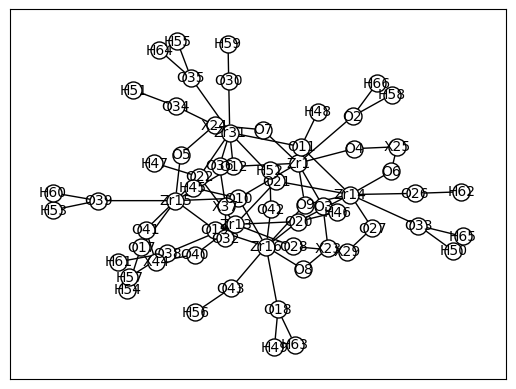

In [4]:
ciffile = '6c_Zr_1_Ch.cif'
dummy_ciffile = ciffile.removesuffix('.cif')+'_dummy.cif'
sG,unit_cell=cif2G(ciffile,'nodes')
options = {
            "font_size": 10,
            "node_size": 150,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }
nx.draw_networkx(sG,**options)


In [5]:
ind_max = max([int(nl(n)) for n in list(sG.nodes())])

In [6]:
from src.MOFbuilder.functions.place_bbs import superimpose
def get_diagonal_pair(array1):
    max_length=0
    min_length=100
    for i in range(1):
        for j in  range(1,len(array1)):
            v= array1[i]-array1[j]
            length = np.linalg.norm(v)
            if length>max_length:
                max_length=length
                diag_pair=j
            if length<min_length:
                min_length=length
                near_pair=j
    return np.asarray((array1[0],array1[diag_pair],array1[near_pair]))

template_Zr_D=np.array(
    ([ 0.70710678 , 0.70710678,  0.        ],
    [-0.70710678 , 0.70710678,  0.        ],
    [-0.70710678 ,-0.70710678,  0.        ],
    [ 0.70710678 ,-0.70710678,  0.        ],
    [ 0.         , 0.70710678,  0.70710678],
    [ 0.         ,-0.70710678,  0.70710678],
    [ 0.         ,-0.70710678, -0.70710678],
    [ 0.         , 0.70710678, -0.70710678])
    )

def order_ccoords(d_ccoords,template_Zr_D):
    ccords_pair=get_diagonal_pair(d_ccoords)
    template_pair=get_diagonal_pair(template_Zr_D)
    min_dist,rot,tran = superimpose(template_pair,ccords_pair)
    ordered_ccoords=np.dot(template_Zr_D,rot)+tran
    return ordered_ccoords

neig ['O2', 'O3', 'O4', 'O7', 'O9', 'O10', 'O11', 'O12']
[62, 3, 1]
neig ['O32', 'O38', 'O40', 'O28', 'O19', 'O20', 'O21', 'O22']
[58, 9, 3, 3, 1]
neig ['O6', 'O9', 'O11', 'O33', 'O26', 'O27', 'O20', 'O21']
[46, 9, 9, 3, 3, 3, 3, 3, 2, 1]
neig ['O5', 'O10', 'O12', 'O17', 'O39', 'O41', 'O19', 'O22']
[17, 17, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1]
neig ['O8', 'O9', 'O10', 'O42', 'O43', 'O18', 'O19', 'O20']
[17, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1]
neig ['O11', 'O12', 'O21', 'O22', 'O30', 'O34', 'O35', 'O36']
[9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


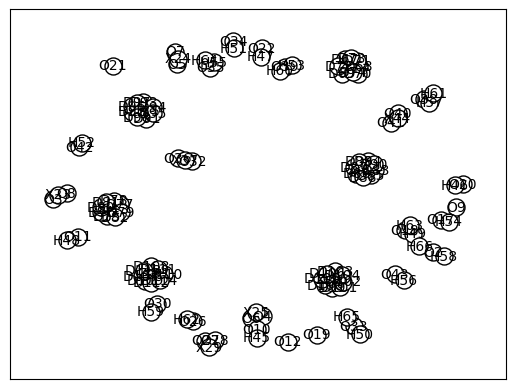

In [7]:
metal_nodes = [n for n in list(sG.nodes()) if nn(n)=='Zr']
count = ind_max+1
for mn in metal_nodes:
    neighbor_nodes = list(nx.neighbors(sG,mn))
    print('neig',neighbor_nodes)
    Ocheck = all(nn(i)=='O' for i in neighbor_nodes)
    if (len(neighbor_nodes)==8 and Ocheck):
        #add dummy
        beginning_cc = sG.nodes[mn]['ccoords']
        beginning_fc = sG.nodes[mn]['fcoords']
        index= sG.nodes[mn]['index']
        d_ccoords=[]
        d_fcoords =[]
        for nO in neighbor_nodes:
            sO = sG.nodes[nO]['ccoords']
            cnorm_vec = (sO - beginning_cc)/np.linalg.norm(sO - beginning_cc) #1 angstrom
            #f_vec = np.dot(np.linalg.inv(unit_cell),cnorm_vec)
            d_ccoord = beginning_cc+cnorm_vec
            #d_fcoord = beginning_fc+f_vec
            d_ccoords.append(d_ccoord)
            #d_fcoords.append(d_fcoord)
            sG.remove_edge(mn,nO)
        print([len(c) for c in sorted(nx.connected_components(sG), key=len, reverse=True)])
        #order ccords based on template order
        ordered_ccoords=order_ccoords(d_ccoords,template_Zr_D)
        ordered_fcoords = np.dot(ordered_ccoords,np.linalg.inv(unit_cell))
        for row in range(len(d_ccoords)):
            sG.add_node('D'+str(count), type='D', index=index, ccoords=ordered_ccoords[row] , fcoords=ordered_fcoords[row] , cn=[], cifname=[])
            sG.add_edge(mn,'D'+str(count))
            count+=1

nx.draw_networkx(sG,**options)

In [8]:
nx.number_of_nodes(sG)

114

In [9]:
arr = np.empty((sG.number_of_nodes(),4),dtype='O')
row=0
for n in list(sG.nodes()):
    arr[row,0] = n
    s = sG.nodes[n]['ccoords']
    arr[row,1] = s[0]
    arr[row,2] = s[1]
    arr[row,3] = s[2]
    row+=1

In [10]:
sG_subparts=[c for c in sorted(nx.connected_components(sG), key=len, reverse=True)]
sorted(nx.connected_components(sG))

[{'D67', 'D68', 'D69', 'D70', 'D71', 'D72', 'D73', 'D74', 'Zr1'},
 {'H58', 'H66', 'O2'},
 {'O3', 'O8', 'X23'},
 {'O4', 'O6', 'X25'},
 {'O5', 'O7', 'X24'},
 {'O9'},
 {'H45', 'O10'},
 {'H48', 'O11'},
 {'O12'},
 {'D75', 'D76', 'D77', 'D78', 'D79', 'D80', 'D81', 'D82', 'Zr13'},
 {'D83', 'D84', 'D85', 'D86', 'D87', 'D88', 'D89', 'D90', 'Zr14'},
 {'D91', 'D92', 'D93', 'D94', 'D95', 'D96', 'D97', 'D98', 'Zr15'},
 {'D100', 'D101', 'D102', 'D103', 'D104', 'D105', 'D106', 'D99', 'Zr16'},
 {'H54', 'O17'},
 {'H49', 'H63', 'O18'},
 {'O19'},
 {'H46', 'O20'},
 {'O21'},
 {'H47', 'O22'},
 {'H62', 'O26'},
 {'O27', 'O28', 'X29'},
 {'H59', 'O30'},
 {'D107', 'D108', 'D109', 'D110', 'D111', 'D112', 'D113', 'D114', 'Zr31'},
 {'O32', 'O36', 'X37'},
 {'H50', 'H65', 'O33'},
 {'H51', 'O34'},
 {'H55', 'H64', 'O35'},
 {'H57', 'H61', 'O38'},
 {'H53', 'H60', 'O39'},
 {'O40', 'O41', 'X44'},
 {'H52', 'O42'},
 {'H56', 'O43'}]

In [11]:
head = []
tail = []
for sub in sG_subparts:
    l = [nn(i)for i in sub]
    if 'X' not in l:
        head.append(sorted(sub))
    else:
        tail.append(sorted(sub))

In [12]:
sub_headlens = [len(i) for i in head]
sub_taillens = [len(i) for i in tail]
sum(sub_headlens)+sum(sub_taillens),sub_headlens,sub_taillens

(114,
 [9,
  9,
  9,
  9,
  9,
  9,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1],
 [3, 3, 3, 3, 3, 3])

In [13]:
dummy_count=0
hho_count=0
ho_count=0
o_count=0
ooc_count = 0

for i in sub_headlens:
    if i==3:
        hho_count+=1
    elif i==2:
        ho_count+=1
    elif i==1:
        o_count+=1
    else:
        dummy_count+=1
        dummy_res_len=i
for j in sub_taillens:
    if j == 3:
        ooc_count+=1

node_split_dict = {}
node_split_dict['HHO_count']=hho_count
node_split_dict['HO_count'] = ho_count
node_split_dict['O_count'] = o_count
node_split_dict['METAL_count'] = dummy_count
node_split_dict['dummy_res_len'] = dummy_res_len
node_split_dict['OOC_count'] = ooc_count
node_split_dict['inres_count'] = hho_count+ho_count+o_count+dummy_count
        

In [14]:
node_dict_name=dummy_ciffile.removesuffix('.cif')+'_dict'
node_dict_path = os.path.join('nodes', node_dict_name)
with open(node_dict_path,'w') as f:
    for key in list(node_split_dict):
        f.write('{:20} {:<4}'.format(key, node_split_dict[key]))
        f.write('\n')


In [15]:
def lines_of_atoms(subgraph,subgraph_nodes):
    count =1
    rows = []
    for sn in subgraph_nodes:
        label = subgraph.nodes[sn]['type']
        coord = subgraph.nodes[sn]['ccoords']
        name = sn#label+str(count)
        count+=1
        rows.append([name,label,coord[0],coord[1],coord[2]])

    return rows

def get_bonds_from_subgraph(subgraph):
    bonds =[]
    for e in list(subgraph.edges()):
        atom1 = e[0]
        atom2 = e[1]
        length = 1#subgraph.edges[e]['weight']
        sym = '.'
        if nn(atom1)=='X' or nn(atom2[0])=='X':
            bond_type = 'A'
        else:
            bond_type = 'S'
        bonds.append([atom1,atom2,length,sym,bond_type])

    return bonds

In [16]:
subpart_nodes = head+tail
all_lines = []
all_bonds = []

for count_i in range(len(subpart_nodes)):
    subnodes = subpart_nodes[count_i]
    subgraph = nx.subgraph(sG,subnodes)
    all_lines+=lines_of_atoms(subgraph,sorted(subnodes))
    all_bonds+=get_bonds_from_subgraph(subgraph)


In [17]:
import datetime

def create_cif(name_label_coords, bonds, foldername,cifname):
	opath = os.path.join(foldername, cifname)
	
	with open(opath, 'w') as out:
		out.write('data_' + cifname[0:-4] + '\n')
		out.write('_audit_creation_date              ' + datetime.datetime.today().strftime('%Y-%m-%d') + '\n')
		out.write("_audit_creation_method            'MOFbuilder'" + '\n')
		out.write("_symmetry_space_group_name_H-M    'P1'" + '\n')
		out.write('_symmetry_Int_Tables_number       1' + '\n')
		out.write('_symmetry_cell_setting            triclinic' + '\n')
		out.write('loop_' + '\n')
		out.write('_symmetry_equiv_pos_as_xyz' + '\n')
		out.write('  x,y,z' + '\n')
		out.write('_cell_length_a                    ' + '50' + '\n')
		out.write('_cell_length_b                    ' + '50' + '\n')
		out.write('_cell_length_c                    ' + '50' + '\n')
		out.write('_cell_angle_alpha                 ' + '90' + '\n')
		out.write('_cell_angle_beta                  ' + '90' + '\n')
		out.write('_cell_angle_gamma                 ' + '90' + '\n')
		out.write('loop_' + '\n')
		out.write('_atom_site_label' + '\n')
		out.write('_atom_site_type_symbol' + '\n')
		out.write('_atom_site_fract_x' + '\n')
		out.write('_atom_site_fract_y' + '\n')
		out.write('_atom_site_fract_z' + '\n')

		for l in name_label_coords:

			vec = list(map(float, l[2:5]))
			m = np.array(([0.02,0,0],[0,0.02,0],[0,0,0.02]))
			cvec = np.dot(m, vec)
	
			
			cvec = np.mod(cvec, 1)
			extra = '   0.00000  Uiso   1.00       -0.000000'
			out.write('{:7} {:>4} {:>15} {:>15} {:>15}'.format(l[0], l[1], "%.10f" % np.round(cvec[0],10), "%.10f" % np.round(cvec[1],10), "%.10f" % np.round(cvec[2],10)))
			out.write(extra)
			out.write('\n')

		out.write('loop_' + '\n')
		out.write('_geom_bond_atom_site_label_1' + '\n')
		out.write('_geom_bond_atom_site_label_2' + '\n')
		out.write('_geom_bond_distance' + '\n')
		out.write('_geom_bond_site_symmetry_2' + '\n')
		out.write('_ccdc_geom_bond_type' + '\n')

		for b in bonds:
			out.write('{:7} {:>7} {:>5} {:>7} {:>3}'.format(b[0], b[1], "%.3f" % float(b[2]), b[3], b[4]))
			out.write('\n')

create_cif(all_lines,all_bonds,'nodes',dummy_ciffile)

In [18]:
atoms_number = sG.number_of_nodes()
newxyz = []
output = 'dummynodetest.xyz'
with open(output, "w") as fp:
        newxyz.append(str(atoms_number) + "\n" + "generated by MOF_BUILD" + os.path.basename(output).removesuffix('.xyz')+"\n")
        for i in range(atoms_number):
            row = arr[i]
            value_label = row[0]   # atom_label
            #value_label = re.sub(r"\d", "", value_label)
            value_x = float(row[1])  # x
            value_y = float(row[2])  # y
            value_z = float(row[3])  # z
            formatted_line = "%-5s%8.3f%8.3f%8.3f" % (
                value_label,
                value_x,
                value_y,
                value_z,
            )
            newxyz.append(formatted_line + "\n")
        fp.writelines(newxyz)